In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from geomloss import SamplesLoss
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from vectran.data.graphics_primitives import PrimitiveType

from vecopt.contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from vecopt.contrib.handcrafted_data import syn_dataset
from vecopt.data_utils import LinePerturbationPipe, LineBatchRandomShift

DEVICE = 'cuda:1'

In [5]:
renderer = Renderer((64, 64), linecaps='butt', device=DEVICE, dtype=torch.float32)

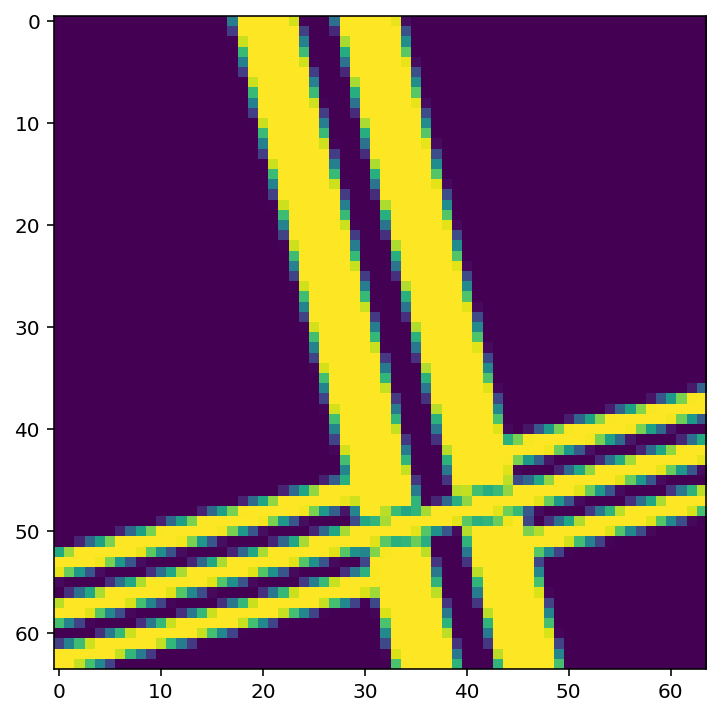

In [6]:
np.random.seed(4)

image_batch = np.zeros((3, 64, 64))
for i in range(3):
    image_batch[i] = 1 - syn_dataset[i]['raster']
image = image_batch[0]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [7]:
def get_pixel_coords_and_density_batch(images):
    batch_size = images.shape[0]
    device = images.device

    nonzero_mask = images > 1e-6
    nonzero_coords = torch.nonzero(nonzero_mask)
    render_n = nonzero_coords[:, 0]
    rc = nonzero_coords[:, 1:].type(torch.float32)
        
    n_nonzero_coords = nonzero_mask.sum(axis=(1, 2))
    n_coords = n_nonzero_coords.max().item()
    
    indices = torch.zeros(n_nonzero_coords.sum().item(), dtype=torch.int64, device=device)
    last = 0
    for elem in n_nonzero_coords:
        idx_range = torch.arange(elem.item(), device=device)
        length = idx_range.shape[0]
        indices[last:(last + length)] = idx_range
        last += length

    coords = torch.zeros(batch_size, n_coords, 2, dtype=torch.float32, device=device)
    coords[render_n, indices] = rc
    
    density = torch.zeros(batch_size, n_coords, dtype=torch.float32, device=device)
    density[render_n, indices] = images[nonzero_mask]
        
    return {
        'nonzero_coords': n_nonzero_coords,
        'coords': coords.to(DEVICE),
        'density': density.to(DEVICE)
    }

In [45]:
np.random.seed(4)
loader = DataLoader(syn_dataset, batch_size=32)

perturber = LinePerturbationPipe(
    LineBatchRandomShift((-6, 6), (0, 1)),
)

n_steps = 300

loss = SamplesLoss('sinkhorn', reach=6., scaling=.6)

for batch in loader:
    rasters = 1. - batch['raster'].to(DEVICE)
    rasters_ot = get_pixel_coords_and_density_batch(rasters)
    
    rasters_ot_coords = rasters_ot['coords'].to(DEVICE)
    rasters_ot_density = rasters_ot['density'].to(DEVICE)
    
    vectors = batch['vector'][PrimitiveType.PT_LINE]
#     vectors = vectors[:, vectors.sum(dim=(0, 2)) != 0, :]
    
    perturbed_lines = perturber.transform(vectors).type(torch.float32).to(DEVICE)
    perturbed_lines.requires_grad_()
    
    optimizer = torch.optim.Adam((perturbed_lines, ), lr=0.25)
    for step in tqdm(range(n_steps)):
        optimizer.zero_grad()
        
        current_renders = renderer.render(perturbed_lines)
        render_ot = get_pixel_coords_and_density_batch(current_renders)
        
        losses = loss(render_ot['density'], render_ot['coords'], rasters_ot_density, rasters_ot_coords)
        losses.sum().backward()
        
        perturbed_lines.grad[:, :, 5] = 0.
        if step < n_steps - 100:
            perturbed_lines.grad[:, :, 4] = 0.
        
        optimizer.step()
    
    break

100%|██████████| 300/300 [03:12<00:00,  1.56it/s]


In [46]:
r = renderer.render(perturbed_lines.to(DEVICE))

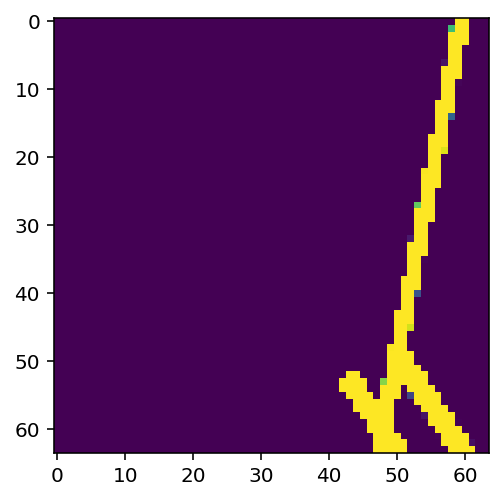

In [61]:
plt.imshow(r[14].detach().cpu().numpy())

In [11]:
current_renders[current_renders > 1e-6]

tensor([0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:1',
       grad_fn=<IndexBackward>)